In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import warnings
import dowhy
from dowhy import CausalModel
from dowhy.causal_identifier import backdoor
from IPython.display import Image, display

warnings.filterwarnings("ignore", category=FutureWarning)

data = pd.read_csv("lalonde_data.csv")

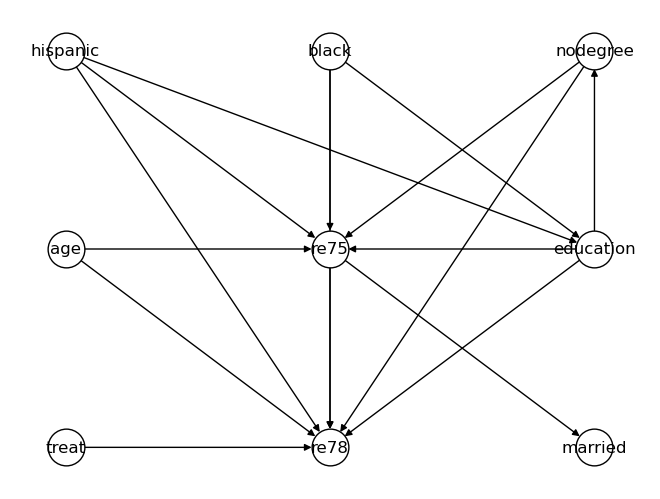

In [50]:
graph_v0 = nx.DiGraph()

var_names = ['treat',
 'age',
 'education',
 'black',
 'hispanic',
 'married',
 'nodegree',
 're75',
 're78']

graph_v0.add_nodes_from(var_names)
graph_v0.add_edges_from([(var_names[0], var_names[8]), (var_names[1], var_names[7]), (var_names[1], var_names[8]), 
                  (var_names[2], var_names[7]), (var_names[2], var_names[8]), (var_names[2], var_names[6]), (var_names[6], var_names[8]),
                  (var_names[7], var_names[5]), (var_names[7], var_names[8]), (var_names[3], var_names[2]), (var_names[4], var_names[2]),
                  (var_names[3], var_names[7]), (var_names[4], var_names[7]), (var_names[3], var_names[8]), (var_names[4], var_names[8]),
                  (var_names[6], var_names[7])])


coordinates = [(-1,-1), (-1, 0), (1, 0), (0, 1), (-1, 1), (1, -1), (1, 1), (0, 0), (0, -1)]
pos= {key: val for key, val in zip(var_names, coordinates)}

nx.draw(graph_v0, pos= pos, with_labels=True, node_size=700, node_color='w', edgecolors ='black')
nx.write_gml(graph_v0, "backdoor_criterion_graph.gml")

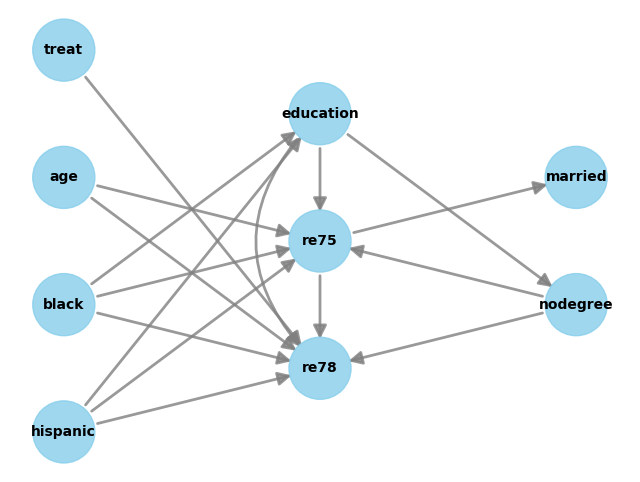

In [51]:
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string

model=CausalModel(
    data = data,
    treatment='treat',
    outcome='re78',
    graph=gml_graph
)
model.view_model() 

In [32]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d             
────────(E[re₇₈])
d[treat]         
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,,U) = P(re78|treat,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [33]:
identifier = model.identifier
identifier.identify_backdoor(model._graph._graph, model._treatment, model._outcome, list(model._graph.get_all_nodes(include_unobserved=False)))

[{'backdoor_set': set()},
 {'backdoor_set': ('black',
   'hispanic',
   'education',
   'age',
   'nodegree',
   'married',
   're75')},
 {'backdoor_set': ('black',)},
 {'backdoor_set': ('hispanic',)},
 {'backdoor_set': ('education',)},
 {'backdoor_set': ('age',)},
 {'backdoor_set': ('nodegree',)},
 {'backdoor_set': ('married',)},
 {'backdoor_set': ('re75',)}]

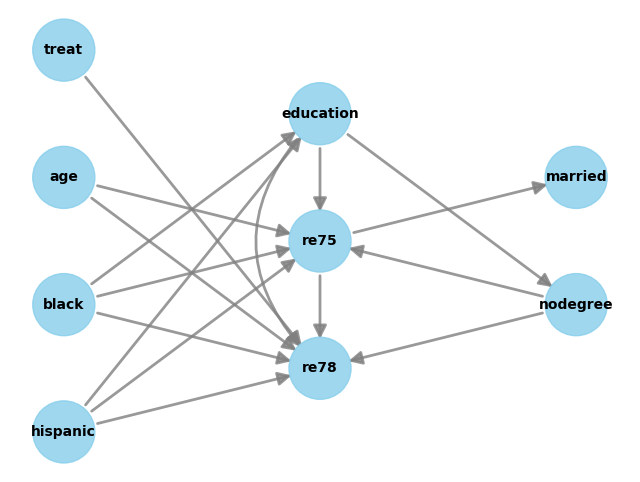

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
───────────(E[re78|education])
d[nodegree]                   
Estimand assumption 1, Unconfoundedness: If U→{nodegree} and U→re78 then P(re78|nodegree,education,U) = P(re78|nodegree,education)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

backdoor.linear_regression ATE : -1204.6728752256586
backdoor.propensity_score_matching ATE: 2613.2093050415497
backdoor.propensity_score_stratification ATE : -1230.1801416602702
backdoor.propensity_score_weighting ATE : -1269.440928621616


In [52]:
# make treatment variable binary
data_binary = data.copy()   
data_binary['education'] = data_binary['education'].apply(lambda x: 1 if x > 8 else 0)
display_data = data_binary.copy()
model=CausalModel(
    data = data_binary,
    treatment='nodegree',
    outcome='re78',
    graph=gml_graph
)
model.view_model()

identified_estimand = model.identify_effect()

print(identified_estimand)

identifier = model.identifier
identifier.identify_backdoor(model._graph._graph, model._treatment, model._outcome, list(model._graph.get_all_nodes(include_unobserved=False)))

estimate_linreg = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print("backdoor.linear_regression ATE :", estimate_linreg.value)

estimate_matching = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
print("backdoor.propensity_score_matching ATE:", estimate_matching.value)

estimate_strat = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print("backdoor.propensity_score_stratification ATE :", estimate_strat.value)

estimate_weight = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting")
print("backdoor.propensity_score_weighting ATE :", estimate_weight.value)




threshold for education: propensity score matching, stratification, weighting
```
5:  -199.53     nan
6:  -272.80     563.94      1435.56
7:  2719.71     672.53      817.39
8:  4604.79     839.63      833.58
9: -1272.04     197.93      206.56
10:  199.84     502.49      512.37
11:-2650.90     1218.71     1246.84
12:-2374.       4654.12     3444.40
...
```

In [35]:
res_random_linreg=model.refute_estimate(identified_estimand, estimate_linreg, method_name="random_common_cause")
print(res_random_linreg)

res_placebo=model.refute_estimate(identified_estimand, estimate_linreg, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_linreg, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_linreg, method_name="add_unobserved_common_cause")
print(res_add)


Refute: Add a random common cause
Estimated effect:-1204.6728752256586
New effect:-1203.4819205969109
p value:0.96



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regre

Refute: Use a Placebo Treatment
Estimated effect:-1204.6728752256586
New effect:0.0
p value:1.0

Refute: Use a subset of data
Estimated effect:-1204.6728752256586
New effect:-1219.8658397538513
p value:0.96

Refute: Add an Unobserved Common Cause
Estimated effect:-1204.6728752256586
New effect:-1180.972489175023



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
res_random_matching=model.refute_estimate(identified_estimand, estimate_matching, method_name="random_common_cause")
print(res_random_matching)

# res_placebo=model.refute_estimate(identified_estimand, estimate_matching, method_name="placebo_treatment_refuter")
# print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_matching, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_matching, method_name="add_unobserved_common_cause")
print(res_add)



Refute: Add a random common cause
Estimated effect:2613.2093050415497
New effect:2613.20930504155
p value:1.0

Refute: Use a subset of data
Estimated effect:2613.2093050415497
New effect:-1912.6973635505171
p value:0.56

Refute: Add an Unobserved Common Cause
Estimated effect:2613.2093050415497
New effect:2505.918102236115



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
res_random_weight=model.refute_estimate(identified_estimand, estimate_weight, method_name="random_common_cause")
print(res_random_weight)

res_placebo=model.refute_estimate(identified_estimand, estimate_weight, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_weight, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_weight, method_name="add_unobserved_common_cause")
print(res_add)

Refute: Add a random common cause
Estimated effect:-1269.440928621616
New effect:-1269.4409286216157
p value:1.0



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_scor

Refute: Use a Placebo Treatment
Estimated effect:-1269.440928621616
New effect:nan
p value:0.0

Refute: Use a subset of data
Estimated effect:-1269.440928621616
New effect:-1310.9066622462071
p value:0.8

Refute: Add an Unobserved Common Cause
Estimated effect:-1269.440928621616
New effect:-1268.2494715132343



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
res_random_propensity=model.refute_estimate(identified_estimand, estimate_weight, method_name="random_common_cause")
print(res_random_propensity)

res_placebo=model.refute_estimate(identified_estimand, estimate_weight, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_weight, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_weight, method_name="add_unobserved_common_cause")
print(res_add)



Refute: Add a random common cause
Estimated effect:-1269.440928621616
New effect:-1269.4409286216157
p value:1.0



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_scor

Refute: Use a Placebo Treatment
Estimated effect:-1269.440928621616
New effect:nan
p value:0.0

Refute: Use a subset of data
Estimated effect:-1269.440928621616
New effect:-1294.754891681722
p value:0.92

Refute: Add an Unobserved Common Cause
Estimated effect:-1269.440928621616
New effect:-1287.605368047456



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# matching


In [39]:
treatment_group = data[data["nodegree"]==1]
control_group = data[data["nodegree"]==0]

treatment_group_x_3 = treatment_group[treatment_group["education"]==3]
treatment_group_x_4 = treatment_group[treatment_group["education"]==4]
treatment_group_x_5 = treatment_group[treatment_group["education"]==5]
treatment_group_x_6 = treatment_group[treatment_group["education"]==6]
treatment_group_x_7 = treatment_group[treatment_group["education"]==7]
treatment_group_x_8 = treatment_group[treatment_group["education"]==8]
treatment_group_x_9 = treatment_group[treatment_group["education"]==9]
treatment_group_x_10 = treatment_group[treatment_group["education"]==10]
treatment_group_x_11 = treatment_group[treatment_group["education"]==11]
treatment_group_x_12 = treatment_group[treatment_group["education"]==12]
treatment_group_x_13 = treatment_group[treatment_group["education"]==13]
treatment_group_x_14 = treatment_group[treatment_group["education"]==14]
treatment_group_x_15 = treatment_group[treatment_group["education"]==15]
treatment_group_x_16 = treatment_group[treatment_group["education"]==16]


control_group_x_3 = control_group[control_group["education"]==3]
control_group_x_4 = control_group[control_group["education"]==4]
control_group_x_5 = control_group[control_group["education"]==5]
control_group_x_6 = control_group[control_group["education"]==6]
control_group_x_7 = control_group[control_group["education"]==7]
control_group_x_8 = control_group[control_group["education"]==8]
control_group_x_9 = control_group[control_group["education"]==9]
control_group_x_10 = control_group[control_group["education"]==10]
control_group_x_11 = control_group[control_group["education"]==11]
control_group_x_12 = control_group[control_group["education"]==12]
control_group_x_13 = control_group[control_group["education"]==13]
control_group_x_14 = control_group[control_group["education"]==14]
control_group_x_15 = control_group[control_group["education"]==15]
control_group_x_16 = control_group[control_group["education"]==16]

print("Number of people with education=3 with nodegree: ", len(treatment_group_x_3)," and with: ", len(control_group_x_3))
print("Number of people with education=4 with nodegree: ", len(treatment_group_x_4)," and with: ", len(control_group_x_4))
print("Number of people with education=5 with nodegree: ", len(treatment_group_x_5)," and with: ", len(control_group_x_5))
print("Number of people with education=6 with nodegree: ", len(treatment_group_x_6)," and with: ", len(control_group_x_6))
print("Number of people with education=7 with nodegree: ", len(treatment_group_x_7)," and with: ", len(control_group_x_7))
print("Number of people with education=8 with nodegree: ", len(treatment_group_x_8)," and with: ", len(control_group_x_8))
print("Number of people with education=9 with nodegree: ", len(treatment_group_x_9)," and with: ", len(control_group_x_9))
print("Number of people with education=10 with nodegree: ", len(treatment_group_x_10)," and with: ", len(control_group_x_10))
print("Number of people with education=11 with nodegree: ", len(treatment_group_x_11)," and with: ", len(control_group_x_11))
print("Number of people with education=12 with nodegree: ", len(treatment_group_x_12)," and with: ", len(control_group_x_12))
print("Number of people with education=13 with nodegree: ", len(treatment_group_x_13)," and with: ", len(control_group_x_13))
print("Number of people with education=14 with nodegree: ", len(treatment_group_x_14)," and with: ", len(control_group_x_14))
print("Number of people with education=15 with nodegree: ", len(treatment_group_x_15)," and with: ", len(control_group_x_15))
print("Number of people with education=16 with nodegree: ", len(treatment_group_x_16)," and with: ", len(control_group_x_16))
      


Number of people with education=3 with nodegree:  1  and with:  0
Number of people with education=4 with nodegree:  6  and with:  0
Number of people with education=5 with nodegree:  5  and with:  0
Number of people with education=6 with nodegree:  7  and with:  0
Number of people with education=7 with nodegree:  15  and with:  0
Number of people with education=8 with nodegree:  62  and with:  0
Number of people with education=9 with nodegree:  110  and with:  0
Number of people with education=10 with nodegree:  162  and with:  0
Number of people with education=11 with nodegree:  195  and with:  0
Number of people with education=12 with nodegree:  0  and with:  122
Number of people with education=13 with nodegree:  0  and with:  23
Number of people with education=14 with nodegree:  0  and with:  11
Number of people with education=15 with nodegree:  0  and with:  2
Number of people with education=16 with nodegree:  0  and with:  1


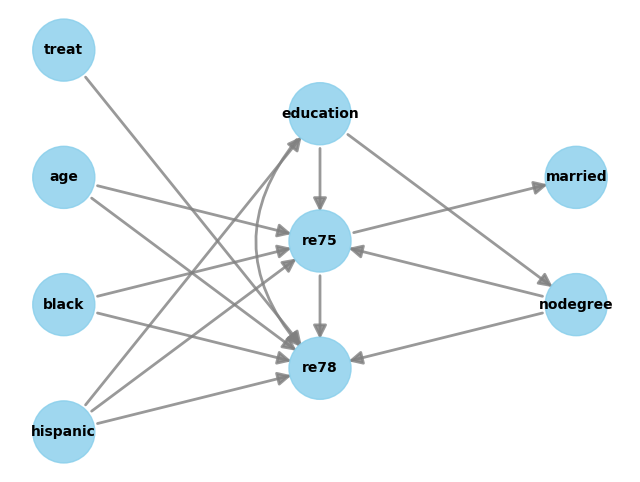

-1144.0912799989856
('treat', 're78')
[-21.13260704350705, 0.0, 0.0, 0.0]
('age', 're75')
[0.0, 0.0, 0.0, 0.0]
('age', 're78')
[0.0, 0.0, 0.0, 0.0]
('education', 're75')
[0.0, 0.0, 0.0, 0.0]
('education', 're78')
[0.0, 0.0, 0.0, 0.0]
('education', 'nodegree')
[-61.57546283236752, nan, nan, nan]
('black', 're75')
[0.0, 0.0, 0.0, 0.0]
('black', 're78')
[0.0, 0.0, 0.0, 0.0]
('hispanic', 'education')
[11.418928163096098, 0.0, 0.0, 0.0]
('hispanic', 're75')
[0.0, 0.0, 0.0, 0.0]
('hispanic', 're78')
[0.0, 0.0, 0.0, 0.0]
('nodegree', 're78')
[0.0, 0.0, 0.0, 0.0]
('nodegree', 're75')
[21.023899707324745, 0.0, 0.0, 0.0]
('re75', 'married')
[0.0, 0.0, 0.0, 0.0]
[[-21.13260704350705, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-61.57546283236752, nan, nan, nan], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [11.418928163096098, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [21.023899707324745, 0.0, 0.0,

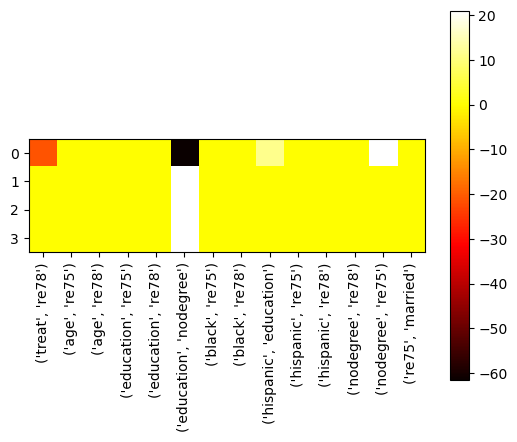

In [47]:
import matplotlib.pyplot as plt
# try dropping each of the edges in the graph and see if the estimate changes
edges = model._graph._graph.edges()

change = [0]*(len(edges)-1)
model.view_model()

print(estimate_linreg.value)

for i, edge in enumerate(list(edges)[:-1]):
    print(edge)
    old_graph = model._graph._graph.copy()
    new_graph = model._graph._graph.copy()
    new_graph.remove_edge(edge[0], edge[1])
    model._graph._graph = new_graph
    identified_estimand = model.identify_effect()
    # model.view_model()
    estim_linreg = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression").value
    try:
        estim_matching = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching").value
    except:
        estim_matching = np.nan
    try:
        estim_strat = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification").value
    except:
        estim_strat = np.nan
    try:
        estim_weight = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting").value
    except:
        estim_weight = np.nan
    change[i] = [estim_linreg-estimate_linreg.value, estim_matching-estimate_matching.value, estim_strat-estimate_strat.value, estim_weight-estimate_weight.value]
    # change[i] = estim_linreg-estimate_linreg.value
    # print(estim_linreg, estim_matching, estim_strat, estim_weight)
    print(change[i])

    model._graph._graph = old_graph



print(change)
plt.imshow(np.array(change).T, cmap='hot', interpolation='nearest')
# plt.x_ticks(range(len(edges)), labels=edges)
plt.xticks(range(len(edges)-1), labels=list(edges)[:-1], rotation=90)
plt.colorbar()
plt.show()





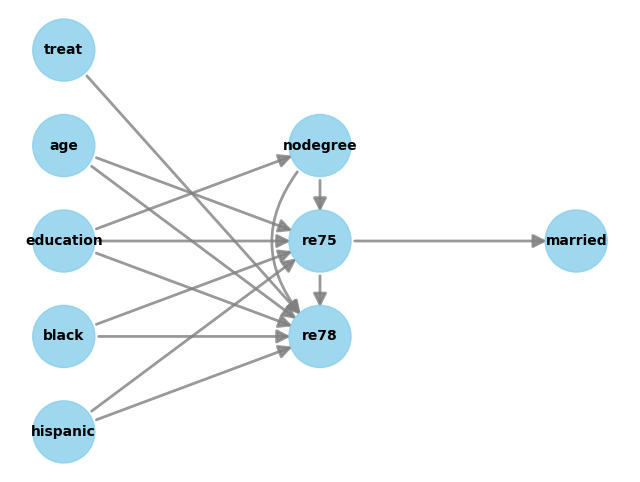

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
───────────(E[re78|education])
d[nodegree]                   
Estimand assumption 1, Unconfoundedness: If U→{nodegree} and U→re78 then P(re78|nodegree,education,U) = P(re78|nodegree,education)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

backdoor.linear_regression ATE : -1132.6723518358895
backdoor.propensity_score_stratification ATE : -1230.1801416602702
backdoor.propensity_score_weighting ATE : -1269.440928621616
Refute: Add a random common cause
Estimated effect:-1132.6723518358895
New effect:-1133.2244009277592
p value:0.98



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regre

Refute: Use a Placebo Treatment
Estimated effect:-1132.6723518358895
New effect:0.0
p value:1.0

Refute: Use a subset of data
Estimated effect:-1132.6723518358895
New effect:-1136.767862095056
p value:0.9

Refute: Add an Unobserved Common Cause
Estimated effect:-1132.6723518358895
New effect:-1111.0379721630516



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Add a random common cause
Estimated effect:-1269.440928621616
New effect:-1269.4409286216157
p value:1.0



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_scor

Refute: Use a Placebo Treatment
Estimated effect:-1269.440928621616
New effect:nan
p value:0.0

Refute: Use a subset of data
Estimated effect:-1269.440928621616
New effect:-1274.2083079485878
p value:0.96

Refute: Add an Unobserved Common Cause
Estimated effect:-1269.440928621616
New effect:-1267.473877729898



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Add a random common cause
Estimated effect:-1269.440928621616
New effect:-1269.4409286216157
p value:1.0



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_scor

Refute: Use a Placebo Treatment
Estimated effect:-1269.440928621616
New effect:nan
p value:0.0

Refute: Use a subset of data
Estimated effect:-1269.440928621616
New effect:-1310.990242566138
p value:0.82

Refute: Add an Unobserved Common Cause
Estimated effect:-1269.440928621616
New effect:-1236.473374493271



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
# drop black -> education and estimate all again
old_graph = model._graph._graph.copy()
new_graph = model._graph._graph.copy()
new_graph.remove_edge('black', 'education')
new_graph.remove_edge('hispanic', 'education')
model._graph._graph = new_graph
model.view_model()
identified_estimand = model.identify_effect()
print(identified_estimand)
estimate_linreg = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print("backdoor.linear_regression ATE :", estimate_linreg.value)
estimate_strat = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print("backdoor.propensity_score_stratification ATE :", estimate_strat.value)
estimate_weight = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting")
print("backdoor.propensity_score_weighting ATE :", estimate_weight.value)

res_random_linreg=model.refute_estimate(identified_estimand, estimate_linreg, method_name="random_common_cause")
print(res_random_linreg)

res_placebo=model.refute_estimate(identified_estimand, estimate_linreg, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_linreg, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_linreg, method_name="add_unobserved_common_cause")
print(res_add)

res_random_propensity=model.refute_estimate(identified_estimand, estimate_weight, method_name="random_common_cause")
print(res_random_propensity)

res_placebo=model.refute_estimate(identified_estimand, estimate_weight, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_weight, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_weight, method_name="add_unobserved_common_cause")
print(res_add)

res_random_weight=model.refute_estimate(identified_estimand, estimate_weight, method_name="random_common_cause")
print(res_random_weight)

res_placebo=model.refute_estimate(identified_estimand, estimate_weight, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_weight, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_weight, method_name="add_unobserved_common_cause")
print(res_add)




In [41]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Original causal effect value
# print("Original Causal Estimate (Linear Regression):", estimate_linreg.value)

# # Define the list of edges to add
# edges_to_add = [
#     ("re75", "treat"),     # Edge 1: Prior earnings -> Treatment
#     ("education", "re75"), # Edge 2: Education -> Prior earnings
#     ("education", "treat"),# Edge 3: Education -> Treatment
#     ("married", "re75"),   # Edge 4: Married -> Prior earnings
#     ("nodegree", "treat")  # Edge 5: No degree -> Treatment
# ]

# # Initialize variables to track changes
# change = []
# new_edges = []

# # Loop through each edge in the list and add it to the graph
# for i, edge in enumerate(edges_to_add):
#     print(f"Inserting edge: {edge}")
#     old_graph = model._graph._graph.copy()
#     new_graph = model._graph._graph.copy()
    
#     new_graph.add_edge(edge[0], edge[1])
#     model._graph._graph = new_graph
    
#     # Identify the causal effect with the modified graph
#     identified_estimand = model.identify_effect()
#     # model.view_model() # Uncomment to view the updated graph
    
#     try:
#         estim_linreg = model.estimate_effect(
#             identified_estimand, 
#             method_name="backdoor.linear_regression"
#         ).value
#     except Exception as e:
#         print(f"Error while estimating with edge {edge}: {e}")
#         estim_linreg = np.nan
#     try:
#         estim_matching = model.estimate_effect(
#             identified_estimand, 
#             method_name="backdoor.propensity_score_matching"
#         ).value
#     except Exception as e:
#         print(f"Error while estimating with edge {edge}: {e}")
#         estim_matching = np.nan
#     try:
#         estim_strat = model.estimate_effect(
#             identified_estimand, 
#             method_name="backdoor.propensity_score_stratification"
#         ).value
#     except Exception as e:
#         print(f"Error while estimating with edge {edge}: {e}")
#         estim_strat = np.nan
#     try:
#         estim_weight = model.estimate_effect(
#             identified_estimand, 
#             method_name="backdoor.propensity_score_weighting"
#         ).value
#     except Exception as e:
#         print(f"Error while estimating with edge {edge}: {e}")
#         estim_weight = np.nan
    
    
#     # Track the change in the causal estimate
#     change.append([estim_linreg - estimate_linreg.value, estim_matching - estimate_matching.value, estim_strat - estimate_strat.value, estim_weight - estimate_weight.value])
#     new_edges.append(edge)
    
#     print(f"New estimate (Linear Regression): {estim_linreg}")
#     print(f"Change in estimate: {change[-1]}")

#     # Restore the original graph
#     model._graph._graph = old_graph

# # Visualize the changes
# print("Changes in causal estimates:", change)
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(new_edges)), change, color="skyblue")
# plt.xticks(range(len(new_edges)), labels=[f"{e[0]}->{e[1]}" for e in new_edges], rotation=45)
# plt.ylabel("Change in Estimate")
# plt.title("Impact of Adding Edges on Causal Estimate")
# plt.show()


In [42]:
# res_random_matching=model.refute_estimate(identifed_estimand_treat, estimate_matching, method_name="random_common_cause")
# print(res_random_matching)

# res_placebo=model.refute_estimate(identified_estimand_treat, estimate_matching, method_name="placebo_treatment_refuter")
# print(res_placebo)

# res_subset=model.refute_estimate(identified_estimand_treat, estimate_matching, method_name="data_subset_refuter")
# print(res_subset)

# res_add=model.refute_estimate(identified_estimand_treat, estimate_matching, method_name="add_unobserved_common_cause")
# print(res_add)

# res_random_strat=model.refute_estimate(identified_estimand_treat, estimate_strat, method_name="random_common_cause")
# print(res_random_strat)

# res_random_weight=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="random_common_cause")
# print(res_random_weight)

# res_placebo=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="placebo_treatment_refuter")
# print(res_placebo)

# res_subset=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="data_subset_refuter")
# print(res_subset)

# res_add=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="add_unobserved_common_cause")
# print(res_add)

# res_random_propensity=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="random_common_cause")
# print(res_random_propensity)

# res_placebo=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="placebo_treatment_refuter")
# print(res_placebo)

# res_subset=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="data_subset_refuter")
# print(res_subset)

# res_add=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="add_unobserved_common_cause")
# print(res_add)

res_random_linreg=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="random_common_cause")
print(res_random_linreg)

res_placebo=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="add_unobserved_common_cause")
print(res_add)

NameError: name 'identified_estimand_treat' is not defined